# Imports

In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
from torch import nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [10]:
# Model

# PubMedBERT: "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"  
# BERT:       "google-bert/bert-base-uncased"

model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
checkpoints_output_dir = "PMB_checkpoints" # directory that will store the model checkpoints
final_output_dir = "PMB_model" # directory that will store the tokenizer and the final (best) model

# Load data
Load data in pandas dataframe.

In [11]:
data_dir = "data"

train_path = os.path.join(data_dir, "train_split.tsv")
val_path = os.path.join(data_dir, "val_split.tsv")

train_df = pd.read_csv(train_path, sep="\t")
val_df = pd.read_csv(val_path, sep="\t")

In [12]:
label_names = ["uninformative", "low", "proper"]
label2id = {label: id for id, label in enumerate(label_names)}
id2label = {id: label for label, id in label2id.items()}

# LLM

## Setting up the Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Helper function to tokenise batch of annotations

In [14]:
def tokenize_batch(texts):
    """
    Takes a list of protein annotations and applies the tokenizer to all of them.
    Arguments:
        texts: list of strings containing the protein annotations.
        max_len: integer indicating the max length of an annotation, needed for padding or truncating tokens.
    Returns:
        BatchEncoding object containing the encoded annotations
    """
    return tokenizer(
        texts,
        padding = True,
        truncation = True,
        max_length = 128
    )

Encoding of training, validation, and test sets.

In [15]:
train_enc = tokenize_batch(texts = train_df["protein_annotation"].tolist())
val_enc = tokenize_batch(texts = val_df["protein_annotation"].tolist())

Class that wraps tokenized annotations and labels into a PyTorch-friendly dataset.

In [16]:
class DS(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # The keys in the encoding object are input_ids, token_types_ids, and attention mask
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = DS(train_enc, train_df["label_id"].tolist())
val_ds = DS(val_enc, val_df["label_id"].tolist())

## Class Weights to Manage Imbalance

In [17]:
classes = np.array(sorted(train_df["label_id"].unique()))
weights = compute_class_weight(
    class_weight = "balanced",
    classes = classes,
    y = train_df["label_id"].values
)
class_weights = torch.tensor(weights, dtype=torch.float)

## Weighted Model

In [18]:
# This automatically attaches a classification head on top of the pretrained encoder (PubMedBERT)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                num_labels=len(label_names),
                                                                id2label=id2label,
                                                                label2id=label2id)


# Custom subclass of the Hugging Face Trainer that overrides the compute_loss method.
# We override because we want to add class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performance Metrics

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "f1_uninformative": f1_score(labels, preds, average=None, labels=[0])[0],
        "f1_low": f1_score(labels, preds, average=None, labels=[1])[0],
        "f1_proper": f1_score(labels, preds, average=None, labels=[2])[0],
    }

## Function to Save Model and Tokenizer

In [20]:
def save(trainer, tokenizer, save_dir):
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Model and Tokenizer saved to {save_dir}")

## Model Training

In [13]:
args = TrainingArguments(
    output_dir=checkpoints_output_dir,
    eval_strategy="epoch",           
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    seed=42,
    remove_unused_columns=True,   
)

trainer = WeightedTrainer(
    model=base_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

save(trainer, tokenizer, final_output_dir)

C:\Users\milap\AppData\Local\Temp\ipykernel_85364\1694936540.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Uninformative,F1 Low,F1 Proper
1,0.575300,0.314221,0.873000,0.709234,0.725664,0.474820,0.927217
2,0.400000,0.198689,0.974000,0.930069,0.882979,0.921053,0.986175
3,0.309900,0.192520,0.965000,0.893298,0.885246,0.813187,0.981460
4,0.177800,0.316051,0.979000,0.934647,0.902857,0.911392,0.989691
5,0.032100,0.381193,0.975000,0.921930,0.883721,0.894118,0.987952
6,0.042700,0.432866,0.972000,0.917875,0.865497,0.902439,0.985690
7,0.053000,0.496844,0.976000,0.926002,0.887574,0.902439,0.987993
8,0.016500,0.409776,0.975000,0.918654,0.883721,0.883721,0.988519
9,0.016600,0.381176,0.976000,0.928447,0.892655,0.904762,0.987924
10,0.008400,0.418170,0.976000,0.924270,0.890173,0.894118,0.988519


Model and Tokenizer saved to PMB_model


## Testing the Model

In [21]:
data_dir = "data"
test_path = os.path.join(data_dir, "test_split.tsv")
test_df = pd.read_csv(test_path, sep="\t")
test_enc = tokenize_batch(texts = test_df["protein_annotation"].tolist())
test_ds = DS(test_enc, test_df["label_id"].tolist())

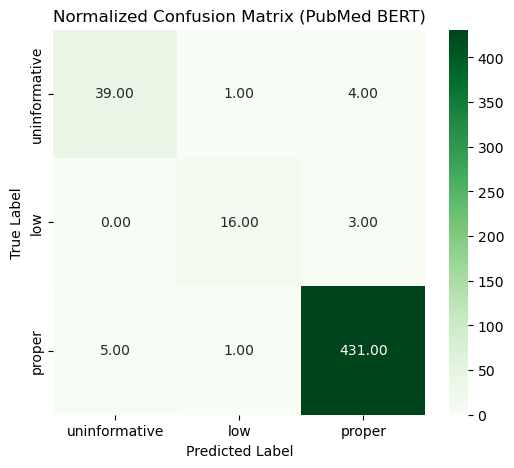

In [25]:
PMB_model = AutoModelForSequenceClassification.from_pretrained("PMB_model")
PMB_trainer = Trainer(model=PMB_model)
predictions = PMB_trainer.predict(test_ds)
y_true = np.array(test_df["label_id"])
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)  # normalize by row (true label)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Greens", fmt=".2f",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (PubMed BERT)")
plt.show()

## Making Predictions

In [29]:
PMB_classifier = pipeline("text-classification", model = "PMB_model")
annotation ="Domain of known function"
pred = PMB_classifier(annotation)
pred

Device set to use cuda:0


[{'label': 'low', 'score': 0.9964979887008667}]